In [1]:
! pip install lightgbm

In [2]:
! pip install catboost

In [3]:
! pip install optuna

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
import string
import nltk
from nltk.corpus import stopwords
import dask.dataframe as dd

from sklearn.model_selection import train_test_split

import optuna

from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

import warnings 
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

# Загрузка данных

In [5]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [6]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [7]:
df.isna().mean()

text     0.0
toxic    0.0
dtype: float64

In [8]:
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Вывод: всего 159292 строк с комментариями, пропусков и дубликатов в датасете нет, он готов к предобработке.

# Предообработка данных

Лемматризируем текст (приведем слова к начальной форме) с помощью библиотеки spaCy:

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #создаем лемматизатор для слов на английском

In [11]:
df = dd.from_pandas(df, npartitions=4)  # создаем Dask DataFrame
# пишем функцию и вместо apply() будем использовать map()
def lemmatize_text(text):
    document = nlp(text)
    lemmas = [token.lemma_ for token in document]
    return ' '.join(lemmas)

%time df['lemmatized_text'] = df['text'].map(lemmatize_text, meta=('lemmatized_text', 'str')).compute()  

Wall time: 13min 58s


In [12]:
df = df.compute()  #вернет файл в формат pandas

- с помощью этого списка уберем слова, которые чаще всего повторяются:

In [13]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
len(stop_words) #в списке 179 слов

179

Текст приведен к начальной форме, но в нем все еще много лишних элементов. Очистим текст от лишних символов, дат и символов:

- если вдруг в тексте есть даты, уберем их с помощью след. списка:

In [15]:
dates = [str(x) for x in np.arange(1900,2022)] 

- еще необходимо создать токенезатор, который разобьет предложения на токены:

In [16]:
word_tokenizer = nltk.WordPunctTokenizer() #создали токенезатор

Все готово для создания функции очистки текста: 

In [17]:
def process_data(row):
    text_lower = row.lower() #приводим текст к нижнему регистру
    text_lower = re.sub('[^a-z]', ' ', text_lower) # убираем символы
    tokens = word_tokenizer.tokenize(text_lower) #токенезируем текст
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates )] 
    # удаляем все слова, если они входят в стоп список или в пунктуацию, или в список дат (string.punctuation - пунктуация)
    return ' '.join(tokens)

In [18]:
df['clean_text'] = df['lemmatized_text'].apply(process_data)

In [19]:
df.drop('lemmatized_text', axis=1, inplace=True)

In [20]:
df.sample(10)

,text,toxic,clean_text
102417,"""\n\nThanks?=\nI am an African American curren...",0,thanks african american currently reside outsi...
126972,Is this really important??? \n\nOn the July 14...,0,really important july episode raw marella defe...
112071,"""\n\n after further investigation, I am not su...",0,investigation sure inappropriate content know ...
125945,Extraordinary life \n\nhttp://www.sitnews.us/J...,0,extraordinary life http www sitnews us juneall...
150688,"""\n\n Dingley. \n\nJust to put you in the pict...",1,dingley put picture trident tone nothing unusu...
40765,"""\n The link for this article is now http://ww...",0,link article http www medialifemagazine com ar...
7067,"23:34, 22 Jun 2005 (UTC)",0,jun utc
55421,Sam Songo Living \n\nHello. I noticed that you...,0,sam songo living hello notice categorize sam s...
99224,"""\nWP:NPOV does not say what you think it says...",0,wp npov say think say quote attribute choose r...
112721,the serious business that is,0,serious business


# Формирование датасета

In [21]:
X = df['clean_text']

In [22]:
y = df['toxic']

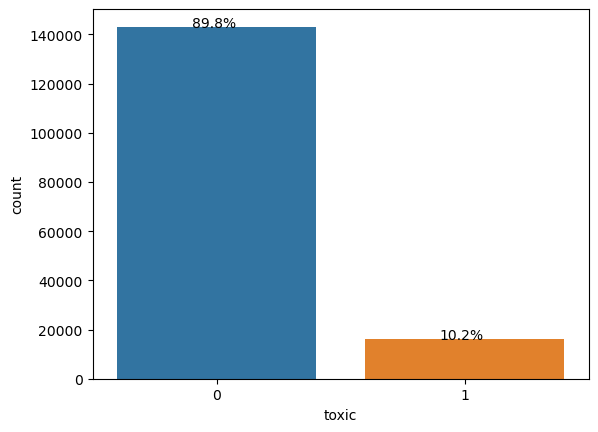

In [23]:
ax = sns.countplot(x='toxic', data=df)

total = len(df['toxic'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    e = p.get_y() + p.get_height() 
    ax.annotate(percentage, (x, e))

plt.show()

In [24]:
y.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Значительный дисбаланс классов, токсичных озывов - 10,2%. Есть несколько методов устранить дисбаланс, но попробуем для начала получить оценку модели без исскуственной манипуляции над данными.

Разделим выборки на обучающую и тестовую:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], y, test_size=0.25, random_state=42, stratify=y)

# Моделирование и оценка

# Логическая регрессия

Первая модель, которую мы рассмотрим - логическая регрессия. Попробуем перебрать для нее некоторые параметры с помощью optuna. Векторизировать данные будем в контейнере трансформации Pipeline, а также применим кросс-валидацию для получения устойчивой оценки:

In [26]:
def objective(trial):

    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        # Гиперпараметр tol определяет, насколько малым должно быть изменение 
        # логарифмической вероятности, чтобы можно было считать, что процесс оптимизации сошелся
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }

    pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr',LogisticRegression(**params)),
])   
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    return cv_f1

Посмотрим на лучшую оценку f1 для модели Логическая регрессия:

Для удобства код закомментирован, а лучшие гиперпараметры сохраним ниже, на случай если модель покажет лучший результат:

In [27]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10)

In [28]:
#study.best_params

In [29]:
#study.best_value

Сохраним значение основной метрики в переменную:

In [30]:
f1_lr = 0.7669749643813032
print(f1_lr)

0.7669749643813032


Сохраним лучшие гиперпараметры: LogisticRegression(C = 57.08809740171897, max_iter =258, tol = 0.024796216134131858, 
                        class_weight = None)

## LGBM Классификатор 

Повторим все действия для следующей модели

In [31]:
def objective(trial):

    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        #'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        #'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
    }
    pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lgbm',LGBMClassifier(**params)),])   
   
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    return cv_f1 


In [32]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10)

In [33]:
#study.best_params

In [34]:
#study.best_value

In [35]:
f1_lgbm=0.7731952871396487

Лучшие параметры: LGBMClassifier(num_leaves = 81, learning_rate = 0.09688948545713519, objective = 'binary', boosting_type='gbdt')

## Сat Boost Классификатор

Для этой модели изменим порядок действий:
- перебора гиперпараметров не будет, используем базовую модель 
- векторизации так же не будет, используем функцию text_features и просто передадим текст в модель.

In [36]:
# пределим обучающую выборку и чать данных для теста и валидации
train_df = df.sample(frac=0.75, random_state=42).copy()
val_df = df[~df.index.isin(train_df.index)].copy()

In [37]:
# выделим валидационную и тестовую выборки
test_df, val_df = val_df.sample(frac=0.5, random_state=42), val_df.drop(val_df.sample(frac=0.5, random_state=42).index)

Размеры выборок:

In [38]:
train_df.shape, val_df.shape, test_df.shape

((119469, 3), (19911, 3), (19912, 3))

Используем готовую модель:

In [39]:
model = CatBoostClassifier(verbose=100, learning_rate=0.7, early_stopping_rounds=200, eval_metric="F1")

Обучаем ее и смотрим на оценку:

In [40]:
model.fit(train_df[['clean_text']], train_df[['toxic']], eval_set=(val_df[['clean_text']], val_df[['toxic']]), text_features=['clean_text'])

0:	learn: 0.6905276	test: 0.7360696	best: 0.7360696 (0)	total: 236ms	remaining: 3m 55s
100:	learn: 0.8024297	test: 0.7766567	best: 0.7776262 (90)	total: 13.3s	remaining: 1m 58s
200:	learn: 0.8213978	test: 0.7706171	best: 0.7776262 (90)	total: 26s	remaining: 1m 43s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7776261937
bestIteration = 90

Shrink model to first 91 iterations.


In [41]:
f1_сat = model.best_score_['validation']['F1']
print(f1_сat)

0.7776261937244203


# Результат

In [42]:
model_scores = pd.DataFrame({'Model':[' LogisticRegression', 'LGBMClassifier', 'CatBoostClassifier'],
                             'F1_score': [f1_lr, f1_lgbm, f1_сat]}) 
model_scores

,Model,F1_score
0,LogisticRegression,0.766975
1,LGBMClassifier,0.773195
2,CatBoostClassifier,0.777626


Таким образом, условие заказчика выполнено на всех трех моделях. При этом лучшая модель - 'CatBoostClassifier', ее приимущество также в том, что она не требует векторизации и мы можем передать в модель обработанный текст.

Протестируем модель-победителя:

In [43]:
model = CatBoostClassifier(verbose=100, learning_rate=0.7, early_stopping_rounds=200, eval_metric="F1")
model.fit(train_df[['clean_text']], train_df[['toxic']], text_features=['clean_text'])
pred = model.predict(test_df[['clean_text']])
print('Все оценки для модели:', classification_report(test_df['toxic'], pred))

0:	learn: 0.6905276	total: 80.7ms	remaining: 1m 20s
100:	learn: 0.8024297	total: 12.6s	remaining: 1m 52s
200:	learn: 0.8213978	total: 24.5s	remaining: 1m 37s
300:	learn: 0.8375507	total: 36.5s	remaining: 1m 24s
400:	learn: 0.8531876	total: 47.8s	remaining: 1m 11s
500:	learn: 0.8697782	total: 58.9s	remaining: 58.7s
600:	learn: 0.8832774	total: 1m 10s	remaining: 46.9s
700:	learn: 0.8939987	total: 1m 22s	remaining: 35.1s
800:	learn: 0.9036298	total: 1m 33s	remaining: 23.3s
900:	learn: 0.9108928	total: 1m 45s	remaining: 11.5s
999:	learn: 0.9185688	total: 1m 56s	remaining: 0us
Все оценки для модели:               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17857
           1       0.85      0.71      0.78      2055

    accuracy                           0.96     19912
   macro avg       0.91      0.85      0.88     19912
weighted avg       0.96      0.96      0.96     19912



In [44]:
print('метрика F1:', round(f1_score(test_df['toxic'], pred),2))

метрика F1: 0.78


Матрица ошибок:

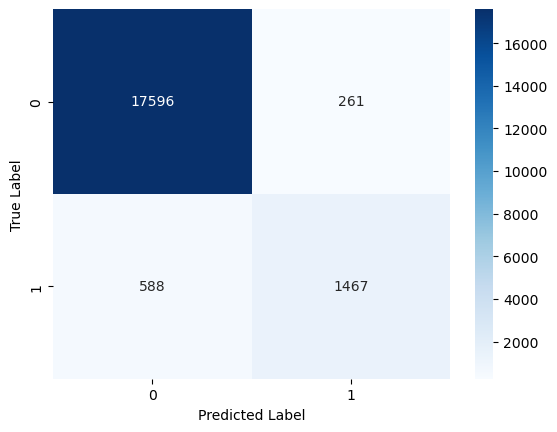

In [45]:
cm = confusion_matrix(test_df['toxic'], pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


На матрице ошибок мы видим, что 588 оценок были не верно классифицированы как положительные отзывы, хотя по факту они являлись негативными, что давольно много. Но так как метрика recall не является основной, модель улучшения не требует. Положительные комментарии определяются верно почти во всех случаях, только 261 комментариев определены неверно, как негативные.